In [1]:
%run ../../src/start.py


python	3.9.6 (default, Jul 30 2021, 16:35:19) 
[GCC 7.5.0]
---------------------
Versions:
----------------------
pandas      1.3.1
numpy       1.20.3
matplotlib  3.4.2
seaborn     0.11.1
plotly      5.1.0
boto3       1.18.16
awswrangler 2.10.0
----------------------


Loaded Libraries
-------------------
import pandas as pd
import numpy as np
import sys,os
import re
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


## AWS
import boto3
import awswrangler as wr
----------------


GLOBAL VARIABLES
--------------------------
# Creating the low level functional client
client = boto3.client(
    's3',
    aws_access_key_id = AWS_KEY_ID,
    aws_secret_access_key = AWS_SECRET,
)
    
# Creating the high level object oriented interface
resource = boto3.resource(
    's3',
    aws_access_key_id = AWS_KEY_I

## Load Data

In [2]:
# helper function
def bucket_raw_path(bucket_name,path_dir):
    ''''''
    raw_path = f's3://{bucket_name}/{path_dir}'
    return raw_path

In [3]:
raw = bucket_raw_path('dend-data',f'capstone/raw-data/weather-data/')
raw

's3://dend-data/capstone/raw-data/weather-data/'

## List objects in bucket

In [4]:
wr.s3.list_objects(raw)

['s3://dend-data/capstone/raw-data/weather-data/b5af47a41a784be4c6fca0b53302f0a1.csv']

## Create dataframe from s3 files

In [5]:
%%time
df = wr.s3.read_csv(raw)

CPU times: user 712 ms, sys: 221 ms, total: 933 ms
Wall time: 14.1 s


In [6]:
## cleanup columns
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('\n','_').str.strip()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151265 entries, 0 to 151264
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt                   151265 non-null  int64  
 1   dt_iso               151265 non-null  object 
 2   timezone             151265 non-null  int64  
 3   city_name            151265 non-null  object 
 4   lat                  151265 non-null  float64
 5   lon                  151265 non-null  float64
 6   temp                 151265 non-null  float64
 7   feels_like           151265 non-null  float64
 8   temp_min             151265 non-null  float64
 9   temp_max             151265 non-null  float64
 10  pressure             151265 non-null  int64  
 11  sea_level            0 non-null       float64
 12  grnd_level           0 non-null       float64
 13  humidity             151265 non-null  int64  
 14  wind_speed           151265 non-null  float64
 15  wind_deg         

In [ ]:
## Select column

In [8]:
df.head()

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1104537600,2005-01-01 00:00:00 +0000 UTC,-21600,Houston,29.760427,-95.369803,293.66,294.09,292.16,293.78,1021,NaN,NaN,89,3.1,100,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
1,1104541200,2005-01-01 01:00:00 +0000 UTC,-21600,Houston,29.760427,-95.369803,292.09,292.65,291.16,292.18,1021,NaN,NaN,100,2.6,100,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03n
2,1104544800,2005-01-01 02:00:00 +0000 UTC,-21600,Houston,29.760427,-95.369803,292.14,292.71,290.18,292.18,1022,NaN,NaN,100,3.6,110,NaN,NaN,NaN,NaN,90,741,Fog,fog,50n
3,1104548400,2005-01-01 03:00:00 +0000 UTC,-21600,Houston,29.760427,-95.369803,291.34,291.83,291.16,291.58,1022,NaN,NaN,100,3.1,130,NaN,NaN,NaN,NaN,90,741,Fog,fog,50n
4,1104552000,2005-01-01 04:00:00 +0000 UTC,-21600,Houston,29.760427,-95.369803,291.07,291.53,290.16,291.58,1022,NaN,NaN,100,3.1,110,NaN,NaN,NaN,NaN,90,741,Fog,fog,50n


## Show null data

In [9]:
df.apply(lambda x: sum(x.isnull()))

dt                          0
dt_iso                      0
timezone                    0
city_name                   0
lat                         0
lon                         0
temp                        0
feels_like                  0
temp_min                    0
temp_max                    0
pressure                    0
sea_level              151265
grnd_level             151265
humidity                    0
wind_speed                  0
wind_deg                    0
rain_1h                123166
rain_3h                151265
snow_1h                151091
snow_3h                151265
clouds_all                  0
weather_id                  0
weather_main                0
weather_description         0
weather_icon                0
dtype: int64

In [10]:
# create null percentage of column as dataframe
null_per_df = pd.DataFrame(df.isna().mean().round(4) * 100)
# rename columns
null_per_df.rename(columns={'index': 'col_name', 0: 'null_percent'}, inplace=True)

# filter data <20% null values
per_filter = null_per_df.null_percent<=90
null_per_df[per_filter].sort_values(by='null_percent',ascending=False)

,null_percent
rain_1h,81.42
dt,0.00
dt_iso,0.00
weather_description,0.00
weather_main,0.00
weather_id,0.00
clouds_all,0.00
wind_deg,0.00
wind_speed,0.00
humidity,0.00


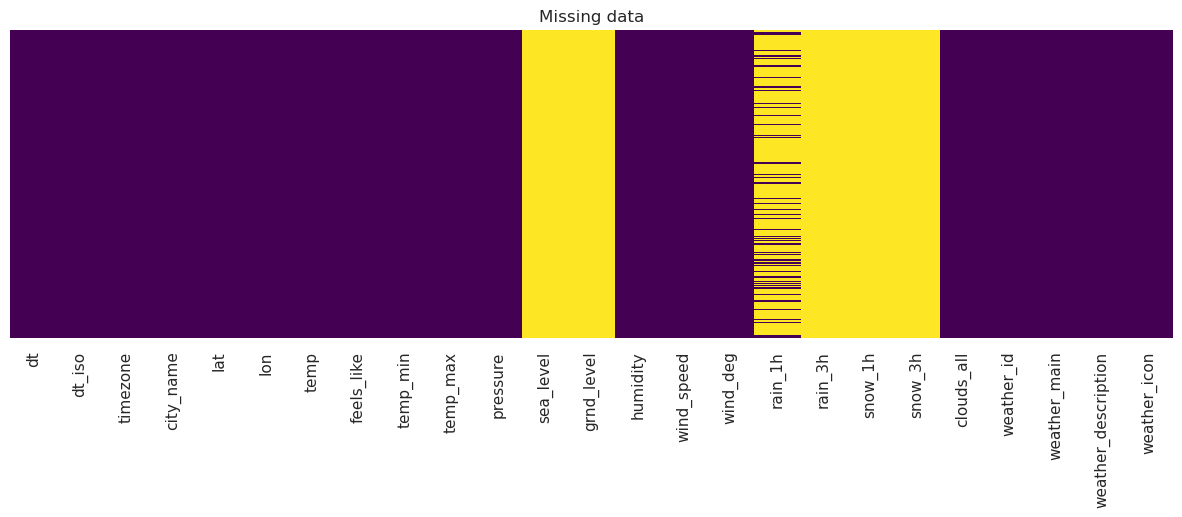

In [11]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Select columns

In [12]:
df = df[['dt','temp', 'feels_like',
 'temp_min',
 'temp_max', 'humidity',
 'wind_speed', 'rain_1h','snow_1h',
 'clouds_all',
 'weather_main',
 'weather_description']]

# https://openweathermap.org/history-bulk
df.rename(columns = {'dt':'date_time', 'clouds_all': 'clouds_all_per','humidity':'humidity_per','rain_1h':'rain_vol_1h_mm',
                       'snow_1h':'snow_vol_1h_mm'}, inplace = True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151265 entries, 0 to 151264
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   date_time            151265 non-null  int64  
 1   temp                 151265 non-null  float64
 2   feels_like           151265 non-null  float64
 3   temp_min             151265 non-null  float64
 4   temp_max             151265 non-null  float64
 5   humidity_per         151265 non-null  int64  
 6   wind_speed           151265 non-null  float64
 7   rain_vol_1h_mm       28099 non-null   float64
 8   snow_vol_1h_mm       174 non-null     float64
 9   clouds_all_per       151265 non-null  int64  
 10  weather_main         151265 non-null  object 
 11  weather_description  151265 non-null  object 
dtypes: float64(7), int64(3), object(2)
memory usage: 13.8+ MB


In [14]:
df.apply(lambda x: sum(x.isnull()))

date_time                   0
temp                        0
feels_like                  0
temp_min                    0
temp_max                    0
humidity_per                0
wind_speed                  0
rain_vol_1h_mm         123166
snow_vol_1h_mm         151091
clouds_all_per              0
weather_main                0
weather_description         0
dtype: int64

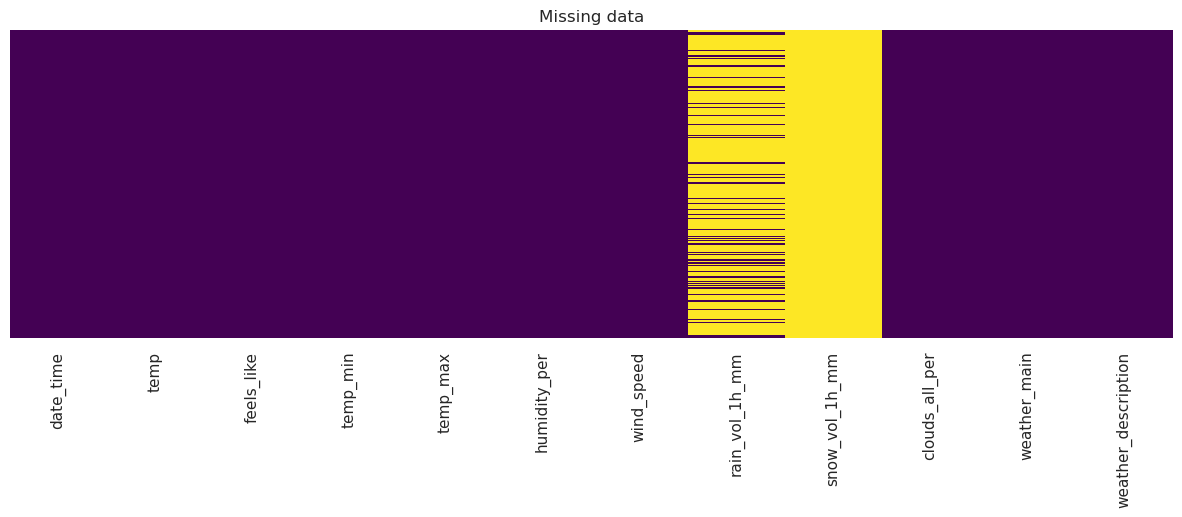

In [15]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

In [16]:
## Change null values to zero
# change nan to zero
df['rain_vol_1h_mm'] = df['rain_vol_1h_mm'].fillna(0)
df['snow_vol_1h_mm'] = df['snow_vol_1h_mm'].fillna(0)

In [17]:
df.apply(lambda x: sum(x.isnull()))

date_time              0
temp                   0
feels_like             0
temp_min               0
temp_max               0
humidity_per           0
wind_speed             0
rain_vol_1h_mm         0
snow_vol_1h_mm         0
clouds_all_per         0
weather_main           0
weather_description    0
dtype: int64

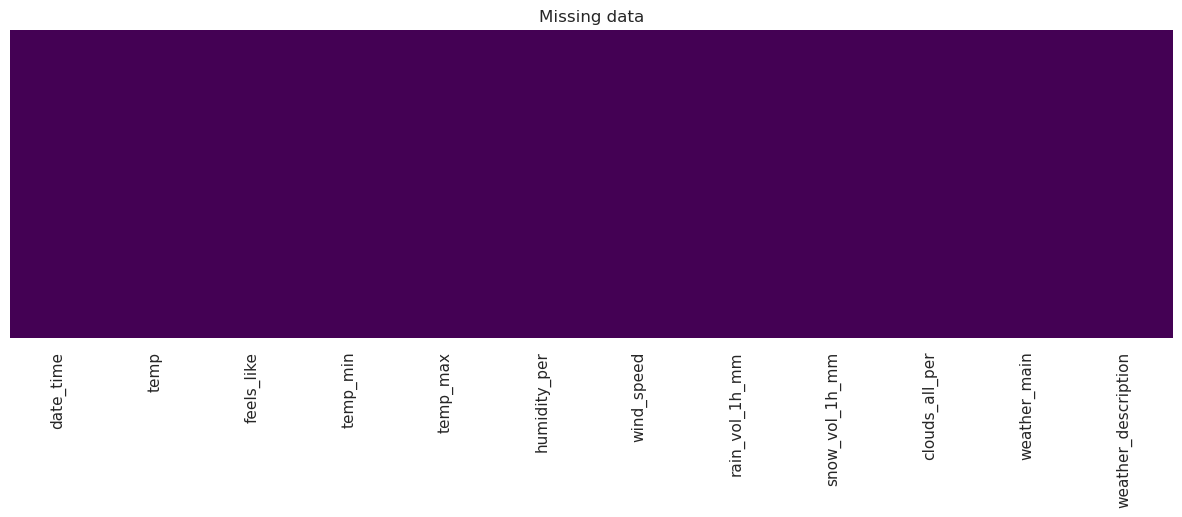

In [18]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Conver tto datetime

In [19]:
# convert to datetime
df.date_time = pd.to_datetime(df['date_time'], unit='s')

## Convert temp

In [20]:
def Celsius_to_Kelvin(C):
    return (C + 273.15)

def Kelvin_to_Celsius(K):
    return (K - 273.15)


def Kelvin_to_Farh(K):
    return (K -273.15) * 9/5 + 32 


def fahr_to_celsius(temp_fahr):
    """Convert Fahrenheit to Celsius
    
    Return Celsius conversion of input"""
    temp_celsius = (temp_fahr - 32) * 5 / 9
    return temp_celsius

In [21]:
df['temp'] = Kelvin_to_Farh(df["temp"])
df['temp_min'] = Kelvin_to_Farh(df["temp_min"])
df['feels_like'] = Kelvin_to_Farh(df["feels_like"])
df['temp_max'] = Kelvin_to_Farh(df["temp_max"])

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151265 entries, 0 to 151264
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date_time            151265 non-null  datetime64[ns]
 1   temp                 151265 non-null  float64       
 2   feels_like           151265 non-null  float64       
 3   temp_min             151265 non-null  float64       
 4   temp_max             151265 non-null  float64       
 5   humidity_per         151265 non-null  int64         
 6   wind_speed           151265 non-null  float64       
 7   rain_vol_1h_mm       151265 non-null  float64       
 8   snow_vol_1h_mm       151265 non-null  float64       
 9   clouds_all_per       151265 non-null  int64         
 10  weather_main         151265 non-null  object        
 11  weather_description  151265 non-null  object        
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 13.8

In [23]:
df.head()

,date_time,temp,feels_like,temp_min,temp_max,humidity_per,wind_speed,rain_vol_1h_mm,snow_vol_1h_mm,clouds_all_per,weather_main,weather_description
0,2005-01-01 00:00:00,68.918,69.692,66.218,69.134,89,3.1,0.0,0.0,75,Clouds,broken clouds
1,2005-01-01 01:00:00,66.092,67.100,64.418,66.254,100,2.6,0.0,0.0,40,Clouds,scattered clouds
2,2005-01-01 02:00:00,66.182,67.208,62.654,66.254,100,3.6,0.0,0.0,90,Fog,fog
3,2005-01-01 03:00:00,64.742,65.624,64.418,65.174,100,3.1,0.0,0.0,90,Fog,fog
4,2005-01-01 04:00:00,64.256,65.084,62.618,65.174,100,3.1,0.0,0.0,90,Fog,fog


In [24]:
df.head().T

,0,1,2,3,4
date_time,2005-01-01 00:00:00,2005-01-01 01:00:00,2005-01-01 02:00:00,2005-01-01 03:00:00,2005-01-01 04:00:00
temp,68.918,66.092,66.182,64.742,64.256
feels_like,69.692,67.1,67.208,65.624,65.084
temp_min,66.218,64.418,62.654,64.418,62.618
temp_max,69.134,66.254,66.254,65.174,65.174
humidity_per,89,100,100,100,100
wind_speed,3.1,2.6,3.6,3.1,3.1
rain_vol_1h_mm,0.0,0.0,0.0,0.0,0.0
snow_vol_1h_mm,0.0,0.0,0.0,0.0,0.0
clouds_all_per,75,40,90,90,90


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151265 entries, 0 to 151264
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date_time            151265 non-null  datetime64[ns]
 1   temp                 151265 non-null  float64       
 2   feels_like           151265 non-null  float64       
 3   temp_min             151265 non-null  float64       
 4   temp_max             151265 non-null  float64       
 5   humidity_per         151265 non-null  int64         
 6   wind_speed           151265 non-null  float64       
 7   rain_vol_1h_mm       151265 non-null  float64       
 8   snow_vol_1h_mm       151265 non-null  float64       
 9   clouds_all_per       151265 non-null  int64         
 10  weather_main         151265 non-null  object        
 11  weather_description  151265 non-null  object        
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 13.8

In [26]:
df.columns.tolist()

['date_time',
 'temp',
 'feels_like',
 'temp_min',
 'temp_max',
 'humidity_per',
 'wind_speed',
 'rain_vol_1h_mm',
 'snow_vol_1h_mm',
 'clouds_all_per',
 'weather_main',
 'weather_description']

In [27]:
df.head()

,date_time,temp,feels_like,temp_min,temp_max,humidity_per,wind_speed,rain_vol_1h_mm,snow_vol_1h_mm,clouds_all_per,weather_main,weather_description
0,2005-01-01 00:00:00,68.918,69.692,66.218,69.134,89,3.1,0.0,0.0,75,Clouds,broken clouds
1,2005-01-01 01:00:00,66.092,67.100,64.418,66.254,100,2.6,0.0,0.0,40,Clouds,scattered clouds
2,2005-01-01 02:00:00,66.182,67.208,62.654,66.254,100,3.6,0.0,0.0,90,Fog,fog
3,2005-01-01 03:00:00,64.742,65.624,64.418,65.174,100,3.1,0.0,0.0,90,Fog,fog
4,2005-01-01 04:00:00,64.256,65.084,62.618,65.174,100,3.1,0.0,0.0,90,Fog,fog


# Select from 2009 to 2018

In [28]:
#greater than the start date and smaller than the end date
start_date = '2009-01-01' #Jan 01 2009
end_date = '2018-12-31' # may 31 2018
mask = (df['date_time'] > start_date) & (df['date_time'] <= end_date)

In [29]:
df2 = df.loc[mask].reset_index(drop=True)
df2.head()

,date_time,temp,feels_like,temp_min,temp_max,humidity_per,wind_speed,rain_vol_1h_mm,snow_vol_1h_mm,clouds_all_per,weather_main,weather_description
0,2009-01-01 01:00:00,58.622,56.210,55.274,59.702,43,5.1,0.0,0.0,1,Clear,sky is clear
1,2009-01-01 02:00:00,56.768,54.212,53.294,57.902,44,7.2,0.0,0.0,1,Clear,sky is clear
2,2009-01-01 03:00:00,55.166,52.412,52.214,56.102,43,6.2,0.0,0.0,1,Clear,sky is clear
3,2009-01-01 04:00:00,53.330,50.522,50.234,54.302,46,4.6,0.0,0.0,1,Clear,sky is clear
4,2009-01-01 05:00:00,51.188,48.308,50.702,52.034,49,3.6,0.0,0.0,1,Clear,sky is clear


## change order of columns

## Save to bucket

In [31]:
bucket = 'dend-data'
year = '09-18'
file_name = f'weather-{year}.csv'
path_to_save = f"s3://{bucket}/capstone/inter-data/weather-data/{file_name}"
path_to_save

's3://dend-data/capstone/inter-data/weather-data/weather-09-18.csv'

In [32]:
%%time
wr.s3.to_csv(df2, path_to_save, index=False)

CPU times: user 936 ms, sys: 88.3 ms, total: 1.02 s
Wall time: 17.7 s


{'paths': ['s3://dend-data/capstone/inter-data/weather-data/weather-09-18.csv'],
 'partitions_values': {}}

## Load that file